In [178]:
import sys
sys.path
sys.path.append('../')

In [195]:
%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params:

In [180]:
aggregate_by_state = False
evaluation_criteria = 'predict current day' #Out of ['hold out counties','predict current day']

## Basic Data Visualization

In [181]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(dir_mod = '../')
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = load_data.outcome_cases # most recent day
outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [182]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
1491


(array([58., 27., 25., 24., 18., 10.,  9.,  9.,  4.,  4., 12.,  6.,  4.,
         2.,  2.,  2.,  2.,  2.,  0.,  2.,  1.,  4.,  1.,  1.,  4.,  2.,
         0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 21.  ,  30.47,  39.94,  49.41,  58.88,  68.35,  77.82,  87.29,
         96.76, 106.23, 115.7 , 125.17, 134.64, 144.11, 153.58, 163.05,
        172.52, 181.99, 191.46, 200.93, 210.4 , 219.87, 229.34, 238.81,
        248.28, 257.75, 267.22, 276.69, 286.16, 295.63, 305.1 , 314.57,
        324.04, 333.51, 342.98, 352.45, 361.92, 371.39, 380.86, 390.33,
        399.8 , 409.27, 418.74, 428.21, 437.68, 447.15, 456.62, 466.09,
  

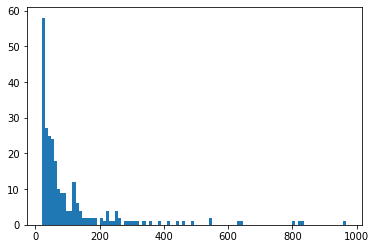

In [183]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [184]:
sum(max_cases)

64450

In [185]:
print(sum([v > 50 for v in max_cases]))


149


In [186]:
np.quantile(max_cases,1)

17856

Number of counties with non-zero deaths
262


(array([106.,   8.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.        ,  11.26666667,  20.53333333,  29.8       ,
         39.06666667,  48.33333333,  57.6       ,  66.86666667,
         76.13333333,  85.4       ,  94.66666667, 103.93333333,
        113.2       , 122.46666667, 131.73333333, 141.        ,
        150.26666667, 159.53333333, 168.8       , 178.06666667,
        187.33333333, 196.6       , 205.86666667, 215.13333333,
        224.4       , 233.66666667, 242.93333333, 252.2       ,
        261.46666667, 270.73333333, 280.        ]),
 <a list of 30 Patch objects>)

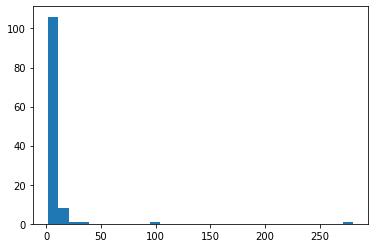

In [187]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

print('Number of counties with non-zero deaths')
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 1],bins=30)

In [188]:
sum(max_deaths)

1031.0

In [189]:
max(max_deaths)

280.0

In [191]:
np.quantile(max_deaths,.5)

0.0

### Clean data

In [192]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
# df_with_cases = df[df['max_cases'] > 0]
df =  df[df['max_cases'] > 0]


In [193]:
if evaluation_criteria == 'hold out counties':
    # Randomly select counties for train/test split

    # Shuffle data
    shuffled_df = df_with_cases.sample(frac=1)
    # Break into train test (random k-fold cross val on the training set is done to pick hyperparams)
    train_ratio, val_ratio, test_ratio = .75,0,.25

    train_df = shuffled_df[0:int(train_ratio*len(shuffled_df))]
    test_df = shuffled_df[int(train_ratio*len(shuffled_df))+int(val_ratio*len(shuffled_df)):]
elif evaluation_criteria == 'predict current day':
    # Train df is all previous days
    # Test df is all days including current day
    previous_deaths = [d[:-1] for d in copy.deepcopy(df['deaths'])]
    previous_cases = [c[:-1] for c in copy.deepcopy(df['cases'])]
    train_df = copy.deepcopy(df)
    train_df['deaths'] = previous_deaths
    train_df['cases'] = previous_cases
    test_df = df
else:
    print('Unknown evaluation criteria')
    raise ValueError



## Predict data from model:

In [196]:
predicted_df_ar = fit_and_predict.fit_and_predict(train_df, test_df, method='AR')
predicted_df_exponential = fit_and_predict.fit_and_predict(train_df, test_df, method='exponential')

## Evaluate and visualize model 

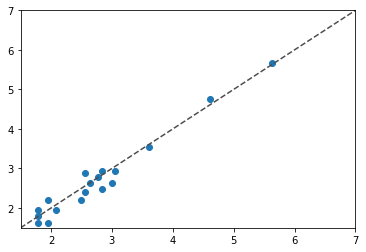

In [47]:
preds = test_df['predicted_deaths_exponential']
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
plt.scatter(np.log(outcome[outcome > 5]), np.log(preds[outcome > 5]))
plt.xlim([1.5, 7])
plt.ylim([1.5, 7])
plt.plot([1.5, 7], [1.5, 7], ls="--", c=".3")

In [197]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    key = 'deaths'
    
    model_predictions = [float(v) for v in row['predicted_deaths']]
    for i,val in enumerate(row[key]):
        if val > 0:
            start_point = i
            break
        
    plt.plot(row[key][start_point:], label=key)
    
    
    plt.plot(model_predictions[start_point:],label='predictions')
    print(model_predictions[start_point:])
    plt.fill_between(list(range(len(row[key][start_point:]))),row[key][start_point:],model_predictions[start_point:])
    plt.legend()
    plt.show()
    

[1.625, 1.75, 7.75, 14.5, 16.75, 26.0, 46.666666666666664, 46.666666666666664, 125.0, 68.00023480228522, 59.658063423427244, 57.79288177494019]


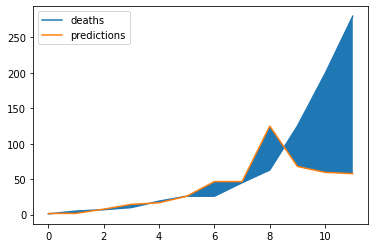

[1.625, 1.75, 1.75, 7.75, 8.25, 12.0, 16.75, 17.0, 20.5, 22.0, 26.0, 27.0, 46.666666666666664, 35.0, 37.0, 43.0, 43.0, 58.0, 58.0, 67.0, 74.0, 75.0, 87.0, 78.39571413706163, 64.40663495224393, 62.669950425827224]


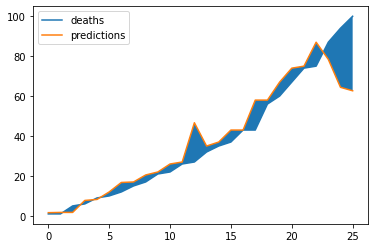

[1.625, 1.75, 2.5, 1.75, 6.3125, 8.25, 12.0, 16.75, 20.5, 20.5, 26.553858385332592, 46.666666666666664]


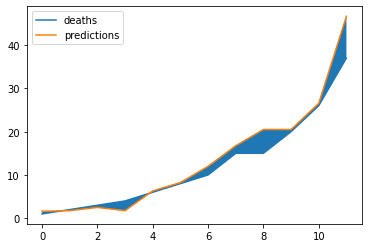

[1.625, 2.5, 2.5, 1.75, 1.75, 1.75, 1.75, 6.3125, 6.3125, 22.0]


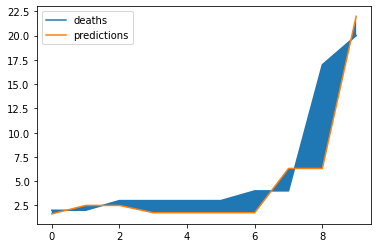

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 6.3125, 7.75, 8.25, 8.25, 12.0, 12.0, 16.75, 16.967532467532468, 19.86826618379357]


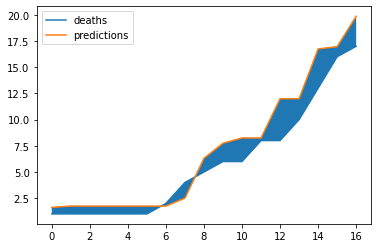

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 1.75, 6.3125, 6.3125, 6.3125, 6.3125, 8.25, 8.25, 14.5, 12.0, 16.75, 16.75, 15.461538461538462, 19.86826618379357]


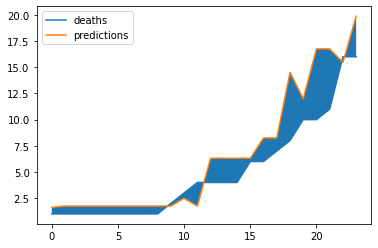

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 2.5, 2.5, 1.75, 6.3125, 8.25, 14.5, 12.0, 17.996786042240586]


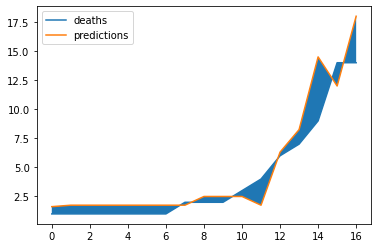

[1.625, 1.75, 1.75, 1.75, 6.3125, 7.75, 12.0, 16.967532467532468]


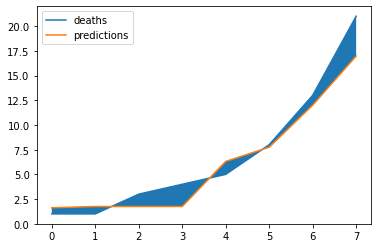

[1.625, 1.75, 1.75, 2.5, 1.75, 6.3125, 8.25, 12.0, 17.0]


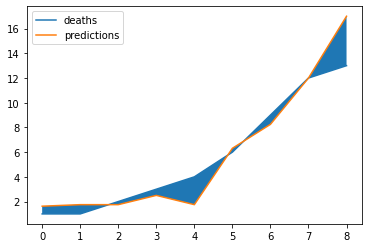

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 2.5, 6.3125, 7.75, 14.5, 15.461538461538462]


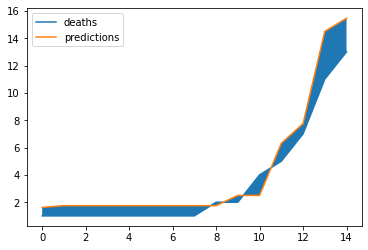

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 6.3125, 14.5, 14.5, 14.5]


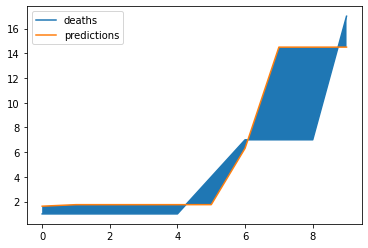

[1.625, 1.75, 2.5, 1.75, 6.3125, 6.3125, 14.5]


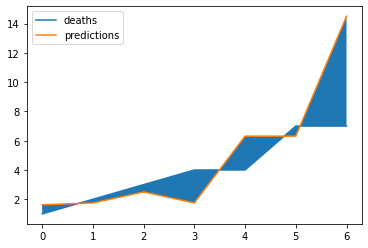

[1.625, 1.75, 1.75, 6.3125, 6.3125, 7.75, 8.25, 14.5]


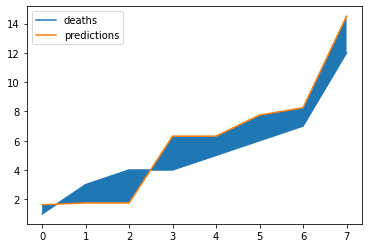

[1.625, 2.5, 1.75, 1.75, 1.75, 6.3125, 7.75, 8.25, 8.25, 8.25]


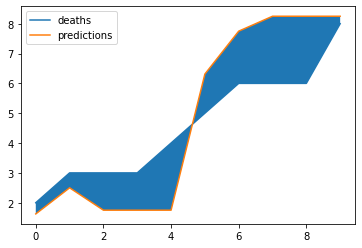

[1.625, 6.3125, 6.3125, 8.25, 8.25, 8.25, 8.25]


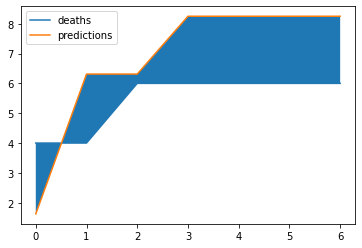

[1.625, 1.75, 1.75, 1.75, 1.75, 2.5, 2.5, 2.5, 6.3125, 8.25]


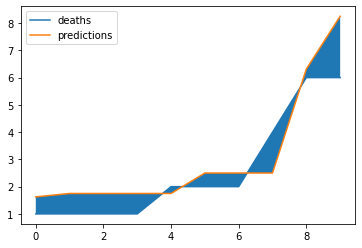

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 7.75, 7.75, 7.75]


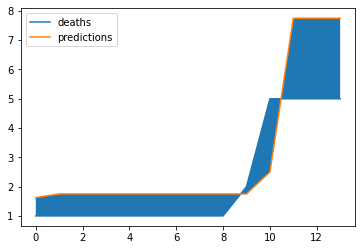

[1.625, 1.75, 1.75, 2.5, 1.75, 1.75, 7.75, 7.75]


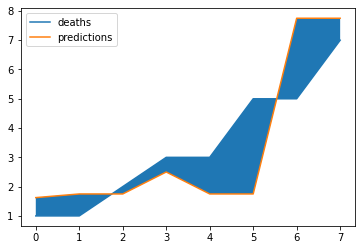

[1.625, 1.75, 1.75, 1.75, 1.75, 6.3125, 7.75]


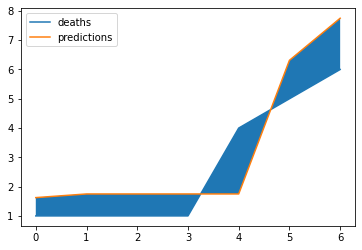

[1.625, 1.75, 1.75, 1.75, 2.5, 2.5, 2.5, 2.5, 2.5, 1.75, 1.75, 7.75]


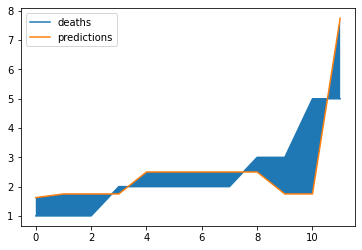

[1.625, 2.5, 1.75, 1.75, 1.75, 1.75, 1.75, 6.3125, 6.3125]


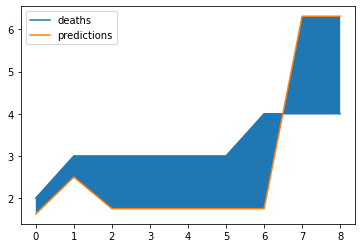

[1.625, 1.75, 1.75, 1.75, 1.75, 6.3125, 6.3125]


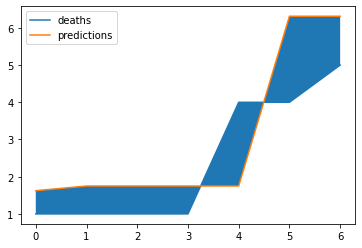

[1.625, 1.75, 1.75, 6.3125, 6.3125]


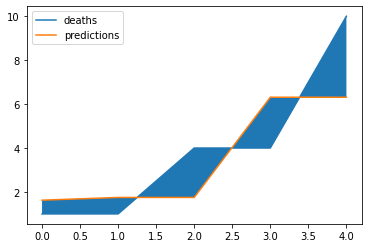

[1.625, 1.75, 1.75, 1.75, 6.3125]


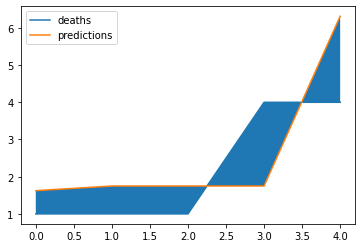

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 2.5, 2.5, 1.75, 1.75, 1.75, 1.75, 6.3125, 6.3125]


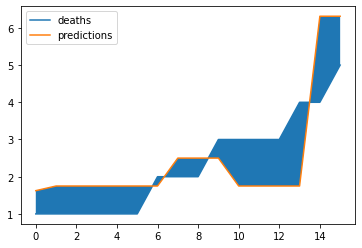

[1.625, 2.5, 2.5, 2.5, 2.5, 2.5, 6.3125]


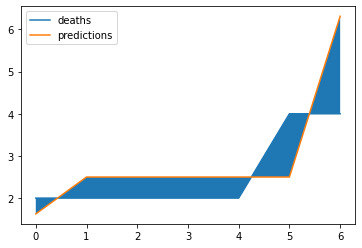

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 1.75, 1.75, 6.3125]


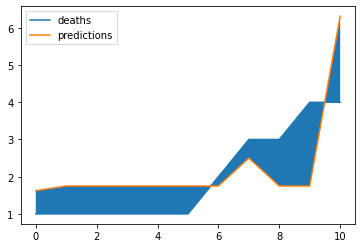

[1.625, 1.75, 1.75, 1.75, 1.75, 2.5, 2.5, 1.75, 1.75, 1.75]


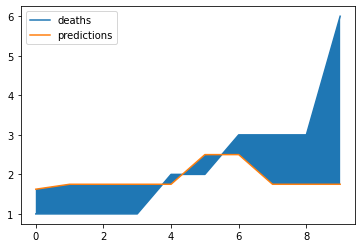

[1.625, 2.5, 1.75]


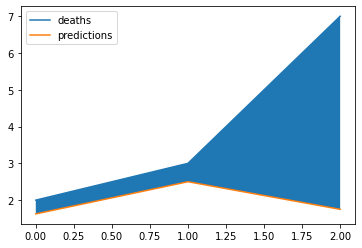

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 1.75, 1.75, 1.75, 1.75]


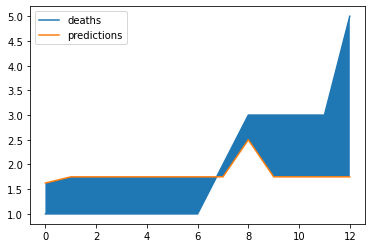

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 2.5, 2.5, 2.5]


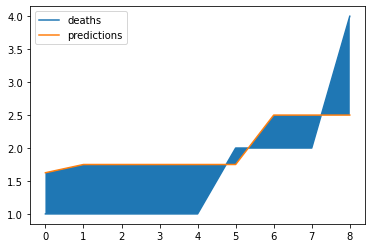

[1.625, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]


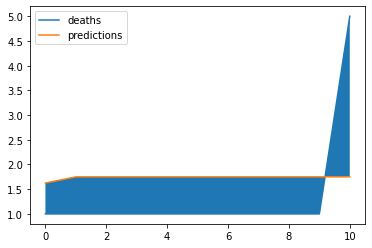

In [198]:
for i in range(len(test_df)):
    row = test_df.iloc[i]
    # If number of deaths greater than 3
    if max(row['deaths']) > 3:
        plot_prediction(row)

In [201]:
# Flatten a list of lists
flatten = lambda l: [item for sublist in l for item in sublist]

def plot_log_dif(df,current_day_only=True,death_threshold = 5):
    preds = list(df['predicted_deaths'])
    outcomes = list(df['deaths'])
    if current_day_only == True:
        preds = [p[-1] for p in preds]
        outcomes = [o[-1] for o in outcomes]
    else:
        preds = flatten(preds)
        outcomes = flatten(outcomes)
        
    filtered_preds = []
    filtered_outcomes = []
    for i in range(len(preds)):
        if outcomes[i] > death_threshold:
            filtered_preds.append(preds[i])
            filtered_outcomes.append(outcomes[i])
        
    plt.scatter([np.log(p) for p in preds], [np.log(o) for o in outcomes])
    plt.plot([1.5, 5.5], [1.5, 5.5], ls="--", c=".3")


/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


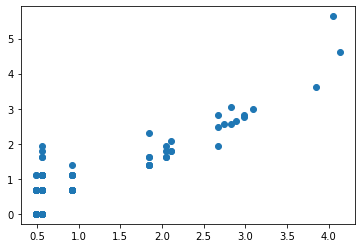

In [202]:
plot_log_dif(test_df)
